# Segmenting lines

${x/y}_{m/M} = \min/\max \{{x/y}_1,{x/y}_2\}$

$(x_M-x_m)^2+(y_M-y_m)^2 = (x_M-x_m+y_M-y_m)^2 - 2 A(R_1+R_2)$

Get bounding boxes of contours, combine rectangles by clustering

In [2]:
import numpy as np
import matplotlib.pyplot as plt

import bbox as bb
import dataset as ds
import preprocess as pr
import htr

In [21]:
from importlib import reload
reload(ds)

<module 'dataset' from '/Users/atadenizaydin/Documents/course material/cs491/nino-server/seg/dataset.py'>

In [22]:
%%time
lins = ds.IAMDataset('lines', 
                     '/Users/atadenizaydin/Documents/course material/cs491/nino-server/mxnet/dataset/iamdataset',
                     msb=True, tabulate=True, sort=True)

CPU times: user 1.84 s, sys: 158 ms, total: 2 s
Wall time: 2.11 s


In [26]:
len(lins)

11344

In [27]:
import cv2

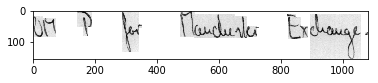

In [53]:
s = lins.samlist[10]
a = cv2.imread(s.path, cv2.IMREAD_GRAYSCALE)
plt.imshow(a, cmap='gray')

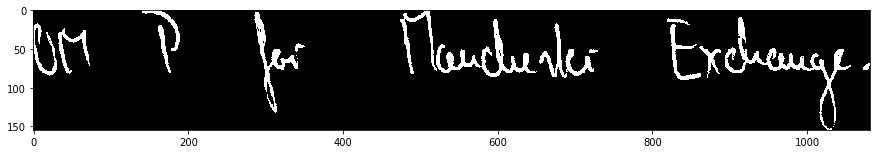

In [54]:
fig = plt.figure()
fig.set_size_inches(15, 8)
plt.imshow(a < s.thres, cmap='gray')

In [41]:
ker = np.ones((3,3),np.uint8)
ac = cv2.morphologyEx(a, cv2.MORPH_OPEN, ker)

In [132]:
ab = cv2.threshold(ac, s.thres, 255, cv2.THRESH_BINARY)[1]

In [158]:
ab = cv2.bitwise_not(ab)

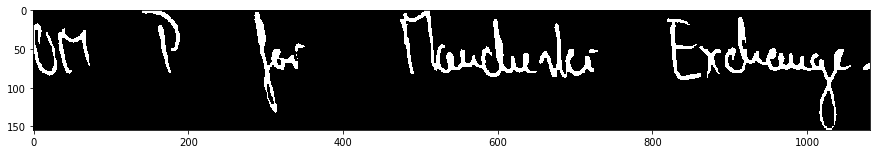

In [159]:
fig = plt.figure()
fig.set_size_inches(15, 8)
plt.imshow(ab, cmap='gray')

In [160]:
retval, labels = cv2.connectedComponents(ab, connectivity=8)

In [161]:
retval

15

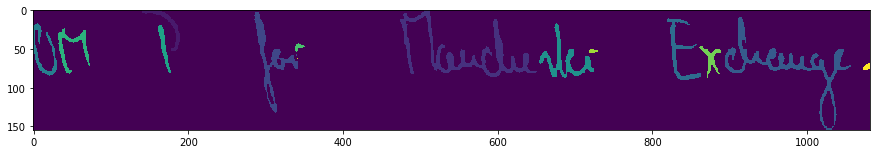

In [162]:
fig = plt.figure()
fig.set_size_inches(15, 8)
plt.imshow(labels)

In [171]:
a2, contours, hierarchy = cv2.findContours(ab, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

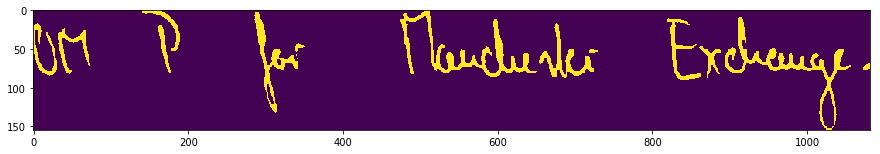

In [172]:
fig = plt.figure()
fig.set_size_inches(15, 8)
plt.imshow(a2)

In [139]:
len(contours)

25

In [174]:
hierarchy

array([[[ 1, -1, -1, -1],
        [ 2,  0, -1, -1],
        [ 3,  1, -1, -1],
        [ 4,  2, -1, -1],
        [ 5,  3, -1, -1],
        [ 6,  4, -1, -1],
        [ 7,  5, -1, -1],
        [ 8,  6, -1, -1],
        [ 9,  7, -1, -1],
        [10,  8, -1, -1],
        [12,  9, 11, -1],
        [-1, -1, -1, 10],
        [15, 10, 13, -1],
        [14, -1, -1, 12],
        [-1, 13, -1, 12],
        [16, 12, -1, -1],
        [-1, 15, -1, -1]]], dtype=int32)

In [359]:
rects = [cv2.boundingRect(contour) for contour in contours]

In [360]:
rects

[(1073, 69, 9, 9),
 (341, 62, 1, 1),
 (719, 51, 11, 4),
 (861, 47, 28, 41),
 (339, 43, 12, 11),
 (32, 23, 42, 60),
 (161, 20, 17, 62),
 (654, 17, 71, 71),
 (0, 17, 31, 68),
 (819, 10, 45, 80),
 (894, 9, 164, 146),
 (1019, 104, 18, 50),
 (286, 2, 57, 131),
 (301, 94, 11, 28),
 (314, 62, 8, 10),
 (475, 0, 176, 87),
 (141, 0, 49, 53)]

In [361]:
reload(bb)

<module 'bbox' from '/Users/atadenizaydin/Documents/course material/cs491/nino-server/seg/bbox.py'>

In [362]:
rects = [bb.Rect(x0,y0,x0+w,y0+h) for (x0,y0,w,h) in rects]

In [363]:
rimg = np.zeros(ac2.shape, dtype='int8')
for rect in rects:
    rimg = cv2.rectangle(rimg, (rect.x0, rect.y1), (rect.x1, rect.y0), 255, 2)

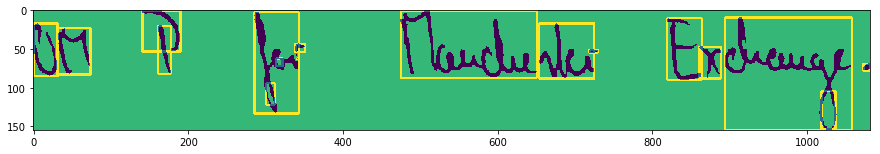

In [364]:
fig = plt.figure()
fig.set_size_inches(15, 8)
plt.imshow(rimg+ac2)

In [365]:
dists = np.array([[(r1+r2).norm() for r2 in rects] for r1 in rects])

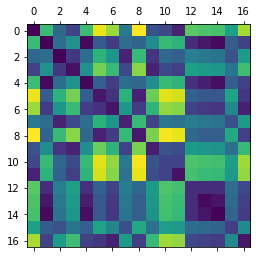

In [366]:
plt.matshow(dists)

In [231]:
cs = np.stack([xs, ys], axis=1)

In [242]:
distsy = np.array([r.max_dist(cs) for r in rects])

In [243]:
distsy.shape

(17, 2)

In [229]:
import sklearn as skl
from sklearn.utils.validation import check_is_fitted

In [245]:
from scipy.special import logsumexp

In [536]:
class DAWordSegmentor(skl.base.BaseEstimator, skl.base.TransformerMixin):
    '''Hierarchical clustering of rectangles using DA
    i.e. copy paste from slt homework'''
    
    def __init__(self, random_state=42, epsilon=.1, delta=.001, metric='avg',
                 iters=None, T_max=100, T_min=1, alpha=.9, maxiter=50, lr=.1, scale=2, verbose=False):
        self.random_state = random_state
        # Add more parameters, if necessary.
        self.epsilon = epsilon # perturbation std
        self.delta = delta # convergence measure
        self.metric = metric # whether to take average or max distance to rectangle
        self.iters = iters # no of iterations
        self.alpha = alpha # temperature decay
        self.maxiter = maxiter # max no of iterations for EM
        self.verbose = verbose # whether to print attributes, for testing
        self.T_max = T_max
        self.T_min = T_min
    
    def fit(self, rects):
        'Fit DA to list of rectangles'
        
        self.rand = np.random.RandomState(self.random_state)
        self.n = len(rects)
        self.K = self.n
        
        np.seterr(invalid='raise', divide='raise')
        
        # start with high temp, one cluster at centroid
        T = T_max = 2*sum(rects, rects[0]).norm()**2/12 # max(r.norm()**2 for r in rects)
        # self.y = (self.rand.randn(self.n, 2) + 1) * T**.5
        
        # cluster probability for each sample and masses for each cluster
        self.pci = np.ones((self.n, self.K)) / self.K
        self.pc = np.ones((self.K,)) / self.K
        
        self.distortion = []
        self.temp = []
        self.area = []
        
        self.X = np.array([rect.center() for rect in rects])
        self.y = self.X + self.epsilon * (T/2)**.5 * self.rand.randn(*self.X.shape)
        
        self.min_d = None
        # self.min_T = T
        # self.min_y = y
        
        # for t in range(self.iters):
        # loop until low temp
        t = 0
        while T:
            t += 1
            if T <= self.T_min and (self.iters is None or t >= self.iters):
                T = 0 # last iteration with hard assignments
            
            # perform em updates until convergence
            self._em(rects, T)
            
            if self.min_d is None or self.distortion[-1] < self.min_d:
                self.min_d = self.distortion[-1]
                self.min_T = self.temp[-1]
                self.min_y = self.y
                self.min_pci = self.pci
                self.min_pc = self.pc
            if self.verbose and not t % self.verbose:
                print('Temp %.2f: %.3f' % (self.temp[-1], self.distortion[-1]))
            
            # cool temp, if critical temp reached for cluster split it
            T *= self.alpha
            
            self.y += self.epsilon * (T_max/2)**.5 * self.rand.randn(*self.y.shape)
        
        return self
    
    def _em(self, rects, T):
        'Repeat EM steps until convergence for given temperature.'
        # for each cluster compute cond and marginal probs, update centroid until convergence
        for _ in range(self.maxiter):
            if self.metric == 'max':
                self.X = np.array([rect.argmax_dist(self.y) for rect in rects])
                assert self.X.shape == (self.n, self.K, 2)
            
            # compute matrix of distortions
            dists = self._distance(rects, self.y, self.X)
            assert dists.shape == (self.n, self.K)
            
            try:
                W = -dists**2/T + np.log(self.pc.reshape(1, -1))
                
                # compute conditional and marginal distributions
                self.pci = np.exp(W - logsumexp(W, axis=1, keepdims=True))
            except: # divide by zero or overflow for low temp
                self.pci = (dists == dists.min(axis=1, keepdims=True))
                # normalize just in case there are multiple maxima
                self.pci = self.pci / self.pci.sum(axis=1, keepdims=True) 
            
            # expectation wrt empirical dist
            self.pc = self.pci.sum(axis=0) / self.n
            
            # compute centroids, calculate average deviation
            pci = self.pci[:,self.pc>0]
            pc = self.pc[self.pc>0]
            y_old = self.y.copy()
            if self.metric == 'avg':
                X = self.X.reshape(-1,1,2)
            else:
                X = self.X[:,self.pc>0]
            self.y[self.pc>0] = (pci.reshape(pci.shape+(1,))*X).sum(axis=0) / self.n / pc.reshape(-1,1)
            assert self.y.shape == (self.K, 2)
            
            if np.linalg.norm(y_old - self.y) / self.K < self.delta:
                break
        
        # update statistics
        self.temp.append(T)
        # expected square loss over x and y
        self.distortion.append(np.trace(self.pci.T.dot(dists**2)) / self.n)
        self.area.append(sum(r.area() for r in self.rects(rects)))
    
    def _distance(self, rects, y, X=None):
        """Calculate distances/distortions from all vectors in X to all vectors in Y.
        
        Args:
            X (np.ndarray): Input array with shape (n, n_features)
            Y (np.ndarray): Input array with shape (m, n_features)
            
        Returns:
            D (np.ndarray): Cluster-distance vectors (n, m)
        """
        if self.metric == 'avg':
            if X is None:
                X = self.X
            return np.linalg.norm(X.reshape(-1,1,2) - y, axis=2)
        
        if X is None:
            X = np.array([rect.argmax_dist(y) for rect in rects])
        assert X.shape == (self.n,) + y.shape
        
        return np.linalg.norm(X - y, axis=2)
    
    def predict(self, X):
        """Predict assignment probability vectors for each sample in X.
        
        Args:
            X (np.ndarray): Input array with shape (new_samples, n_features)
            
        Returns:
            P (np.ndarray): Assignment probability vectors (new_samples, n_clusters) 
        """
        
        new_samples = X.shape[0]
        
        P = np.empty((new_samples, self.n_clusters))
        T = self.T_min
        
        # compute distance matrix
        dists = self._distance(X, self.cluster_centers_)
        W = -dists**2/T + np.log(self.marg_probs_.reshape(1, -1))
        assert W.shape == (new_samples, self.n_clusters)
        
        P = np.exp(W - logsumexp(W, axis=1).reshape(-1,1))
        
        return P
    
    def transform(self, X):
        """Transform X to a cluster-distance space.
        
        In the new space, each dimension is the distance to the cluster centers. 
        
        Args:
            X (np.ndarray): Input array with shape (new_samples, n_features)
            
        Returns:
            Y (np.ndarray): Cluster-distance vectors (new_samples, n_clusters)
        """
        check_is_fitted(self, ["cluster_centers_"])
        
        # new_samples = X.shape[0]
        # Y = np.linalg.norm(X.reshape(new_samples, 1, self.n_features) - \
        #                    self.cluster_centers_.reshape(1, self.n_clusters, self.n_features), axis=2)
        Y = self._distance(X, self.cluster_centers_)
        
        return Y
    
    def rects(self, X):
        res = [[]] * self.K
        ks = np.argmax(self.pci, axis=1)
        for i, rect in enumerate(X):
            res[ks[i]].append(rect)
        for k in range(self.K):
            if res[k]:
                res[k] = sum(res[k], res[k][0])
        return res

In [537]:
seg = DAWordSegmentor(iters=50, verbose=5, T_min=1e-2, metric='avg')

In [538]:
%%time
seg.fit(rects)

Temp 130645.80: 63258.182
Temp 77145.04: 28985.064
Temp 45553.37: 17557.802
Temp 26898.81: 13072.375
Temp 15883.48: 7418.448
Temp 9379.04: 3969.777
Temp 5538.23: 2275.369
Temp 3270.27: 1472.259
Temp 1931.06: 1162.613
Temp 1140.27: 986.557
Temp 673.32: 199.152
Temp 397.59: 193.653
Temp 234.77: 174.858
Temp 138.63: 159.446
Temp 81.86: 170.801
Temp 48.34: 167.723
Temp 28.54: 179.882
Temp 16.85: 159.057
Temp 9.95: 158.319
Temp 5.88: 365.810
Temp 3.47: 805.993
Temp 2.05: 711.478
Temp 1.21: 170.794
Temp 0.71: 170.794
Temp 0.42: 1148.199
Temp 0.25: 805.993
Temp 0.15: 978.031
Temp 0.09: 1076.698
Temp 0.05: 805.993
Temp 0.03: 170.794
Temp 0.02: 365.810
Temp 0.01: 895.972
CPU times: user 1.2 s, sys: 76 ms, total: 1.27 s
Wall time: 1.63 s


DAWordSegmentor(T_max=100, T_min=0.01, alpha=0.9, delta=0.001, epsilon=0.1,
        iters=50, lr=None, maxiter=50, metric='avg', random_state=42,
        scale=None, verbose=5)

In [539]:
seg.min_y

array([[ -55.10184181,  472.19711165],
       [ 373.93076156,   20.6255662 ],
       [ 524.666787  ,  546.67727374],
       [ 246.2397498 ,  225.6184246 ],
       [ 530.61177587,  595.1606276 ],
       [ 118.85718233,  123.02032978],
       [ 391.28130433,  238.44112955],
       [  70.04742466,   14.99060013],
       [ 224.53071943,  401.23579385],
       [-463.43541005,  348.54199837],
       [  42.69368119,  441.27283779],
       [  76.4439129 ,  105.18736073],
       [-110.44355859,   37.31554109],
       [  40.18661717,   85.0745639 ],
       [ 365.4690665 ,  355.89249103],
       [ 384.01693581,  236.13564605],
       [ 401.08031539,  402.86378461]])

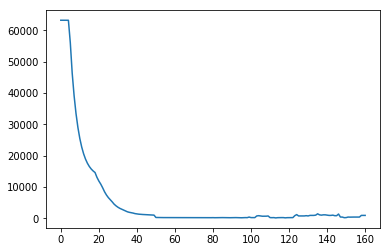

In [554]:
plt.plot(seg.distortion)
plt.show()

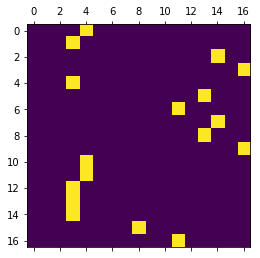

In [560]:
plt.matshow(seg.pci)

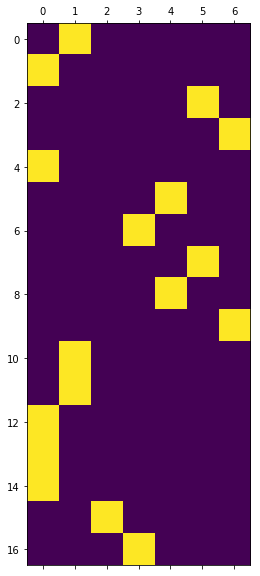

In [561]:
plt.matshow(seg.pci[:,seg.pc>0]>0)

In [542]:
rects0 = [rects[i] for i in range(len(rects)) if seg.pci[:,seg.pc>0][i,0] > 0]
rect0 = sum(rects0, rects0[0])

In [543]:
rect0 == rects0[0]

False

In [544]:
mask = np.zeros(ab.shape)

In [545]:
mask.shape

(155, 1082)

In [546]:
for y in seg.y:
    px, py = int(y[0]), int(y[1])
    try:
        mask = cv2.rectangle(mask, (px, py), (px, py), 255, 2)
    except:
        continue

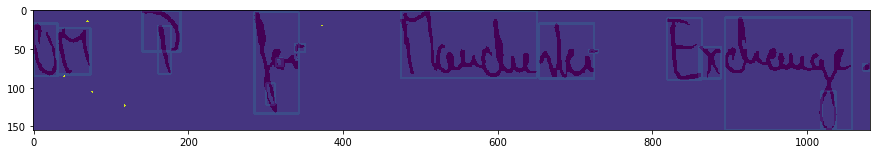

In [547]:
fig = plt.figure()
fig.set_size_inches(15, 8)
plt.imshow(5*mask+rimg+ac2)

In [562]:
ys = np.nonzero(seg.pc>0)[0]

In [563]:
rimg1 = np.zeros(ab.shape, dtype='int8')
for y in ys:
    rects0 = [rects[i] for i in range(len(rects)) if seg.pci[i,y] > 0]
    rect0 = sum(rects0, rects0[0])
    rimg1 = cv2.rectangle(rimg1, (rect0.x0, rect0.y1), (rect0.x1, rect0.y0), 255, 2)

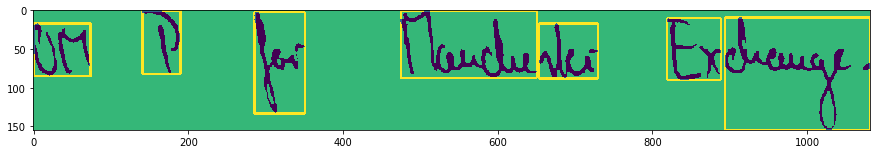

In [564]:
fig = plt.figure()
fig.set_size_inches(15, 8)
plt.imshow(rimg1+ac2)

In [529]:
from sklearn.cluster import DBSCAN
db = skl.cluster.AffinityPropagation(affinity='precomputed').fit(-dists)

In [530]:
inds = np.argsort(db.labels_)

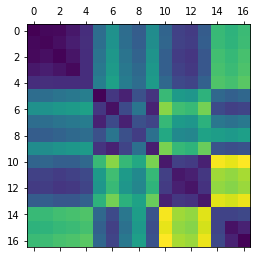

In [531]:
plt.matshow(dists[inds][:,inds])
plt.show()

In [532]:
db.labels_

array([3, 0, 1, 1, 0, 2, 2, 1, 2, 1, 3, 3, 0, 0, 0, 1, 2])

In [534]:
rimg2 = np.zeros(ab.shape, dtype='int8')
for y in np.unique(db.labels_):
    rects0 = [rects[i] for i in range(len(rects)) if db.labels_[i] == y]
    rect0 = sum(rects0, rects0[0])
    rimg2 = cv2.rectangle(rimg2, (rect0.x0, rect0.y1), (rect0.x1, rect0.y0), 255, 2)

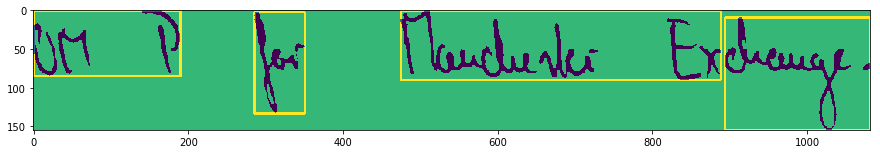

In [535]:
fig = plt.figure()
fig.set_size_inches(15, 8)
plt.imshow(rimg2+ac2)

In [566]:
from sklearn.feature_extraction import image
from sklearn.cluster import spectral_clustering

mask = a>s.thres
graph = image.img_to_graph(a+.2*np.random.randn(*a.shape), mask=mask)

# Take a decreasing function of the gradient: we take it weakly
# dependent from the gradient the segmentation is close to a voronoi
graph.data = np.exp(-(graph.data - graph.data.mean()) / graph.data.std())

# Force the solver to be arpack, since amg is numerically
# unstable on this example
labels = spectral_clustering(graph, n_clusters=5, eigen_solver='arpack')
label_im = np.full(mask.shape, -1.)
label_im[mask] = labels

/Users/atadenizaydin/anaconda2/envs/slt-ce/lib/python3.5/site-packages/sklearn/manifold/spectral_embedding_.py:229: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"
/Users/atadenizaydin/anaconda2/envs/slt-ce/lib/python3.5/site-packages/sklearn/utils/graph.py:115: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if normed and (np.issubdtype(csgraph.dtype, np.int)


KeyboardInterrupt: 